In [1]:
import os
import sys
sys.path.append('/home/gpuvmadm/PyTomography/src')
import numpy as np
import pytomography
from pytomography.io.SPECT import simind
from pytomography.metadata import PSFMeta
from pytomography.priors import RelativeDifferencePrior, NearestNeighbourPrior
from scipy.ndimage import gaussian_filter, binary_dilation
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import colors
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import torch
from scipy.ndimage import zoom

/tmp/ipykernel_14293/4106382690.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
N = 10
times = [1, 2.6, 4.8, 10, 19.9, 38.6, 76.9, 159.6, 307.7, 627]
fs_noprior = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_noprior_scatTEW_dT15_masksGT_niters120_object.npy')) for i in range(N)]
fs_prior = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_RDP_scatTEW_dT15_masksGT_niters120_object.npy')) for i in range(N)]
fs_priorap = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_RDPAP_scatTEW_dT15_masksGT_niters120_object.npy')) for i in range(N)]

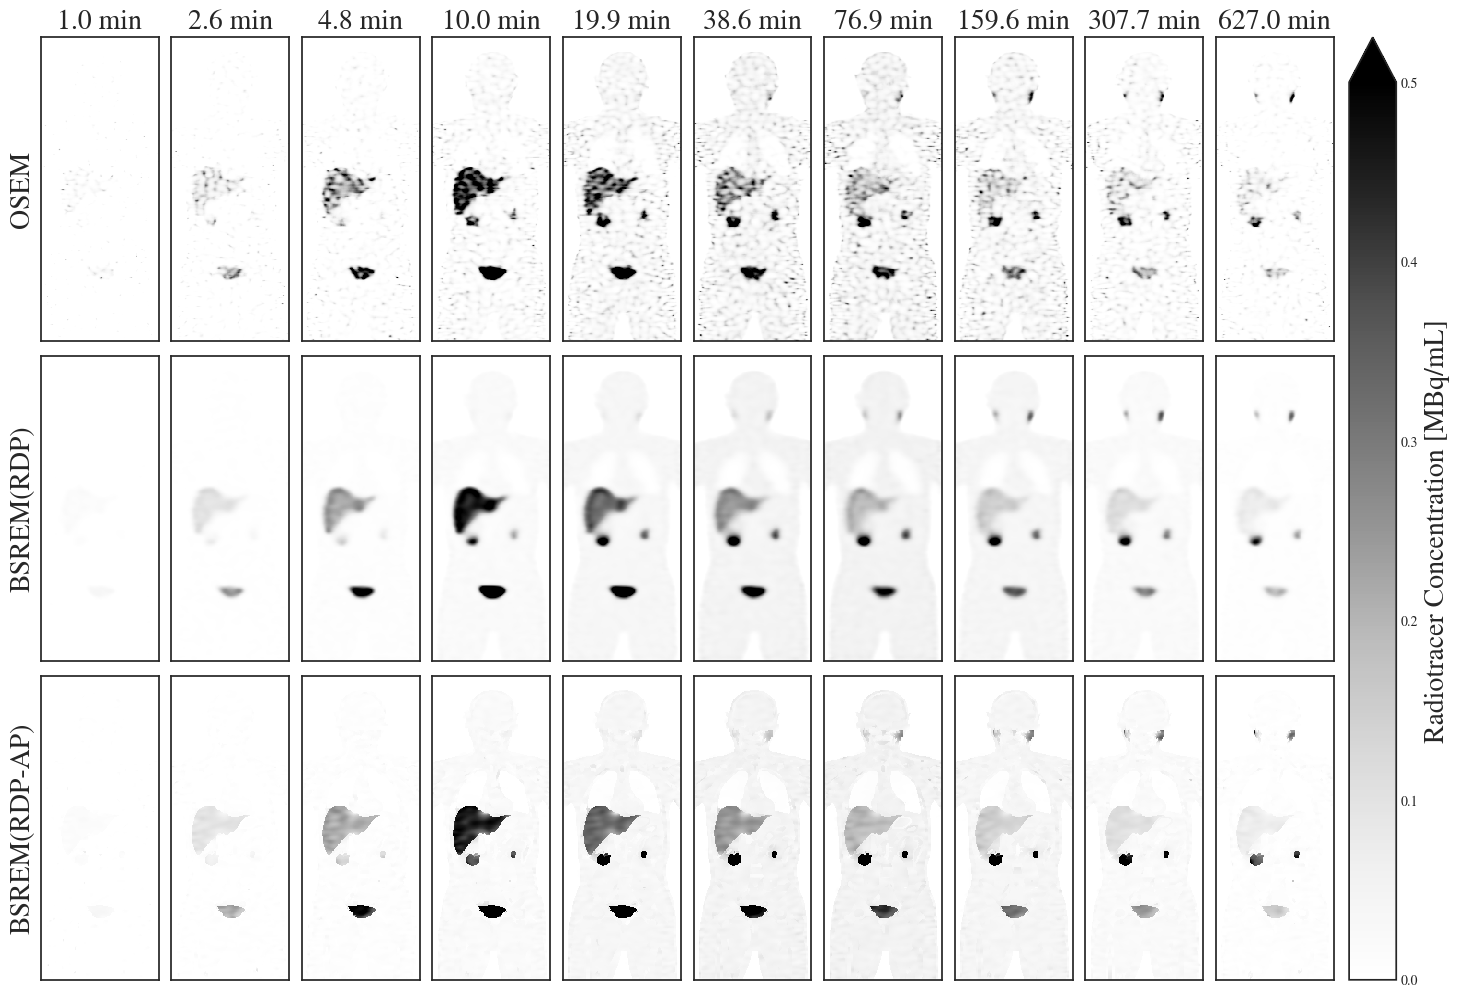

In [3]:
fig, axes = plt.subplots(3,10,figsize=(16,10))
for i in range(10):
    plt.sca(axes[0,i])
    if i<N:
        im = plt.pcolormesh(fs_noprior[i][:,64].T, cmap='Greys', vmin=0, vmax=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{times[i]:.1f} min', fontsize=20)
for i in range(10):
    plt.sca(axes[1,i])
    if i<N:
        im = plt.pcolormesh(fs_prior[i][:,64].T, cmap='Greys', vmin=0, vmax=0.5)
    plt.xticks([])
    plt.yticks([])
for i in range(10):
    plt.sca(axes[2,i])
    if i<N:
        im = plt.pcolormesh(fs_priorap[i][:,64].T, cmap='Greys', vmin=0, vmax=0.5)
    plt.xticks([])
    plt.yticks([])
axes[0,0].set_ylabel('OSEM', fontsize=20)
axes[1,0].set_ylabel('BSREM(RDP)', fontsize=20)
axes[2,0].set_ylabel('BSREM(RDP-AP)', fontsize=20)
fig.tight_layout()
cbar = fig.colorbar(im, ax=axes, location='right', extend='max', pad=0.01)
cbar.set_label(label='Radiotracer Concentration [MBq/mL]', fontsize=20)
plt.savefig('time_evolution_bw.png',bbox_inches='tight', dpi=300)

In [4]:
stats_noprior = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_noprior_scatTEW_dT15_masksGT_niters120.npz')) for i in range(N)]
stats_prior = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_RDP_scatTEW_dT15_masksGT_niters120.npz')) for i in range(N)]
stats_priorap = [np.load(os.path.join('/disk1/multibody_new/', f'organ_concentrations_{i}_reconregular_RDPAP_scatTEW_dT15_masksGT_niters120.npz')) for i in range(N)]

In [5]:
def get_concentration(stats, organ, iter=-1):
    ac_preds = []
    for stat in stats:
        idx = stat['labels']==organ
        ac_preds.append(stat['activity_concs_predicted'][idx,iter])
    return np.array(ac_preds).ravel()

organs = ['liver', 'r_lung', 'salivary', 'bladder', 'r_kidney_cortex', 'r_kidney_medulla']
organs_title = {'r_lung': 'Lungs', 'liver': 'Liver', 'salivary': 'Salivary Glands', 'bladder':'Bladder', 'r_kidney_cortex':'Kidney Cortex', 'r_kidney_medulla':'Kidney Medulla'}
TAC_data = pd.read_csv('/disk1/pytomography_paper_results/data/PBPK_gt.csv')
time = TAC_data['time'].values
GT_dict = {organ: TAC_data[organ].values/1e6 for organ in organs}
fs_noprior_dict = {organ: get_concentration(stats_noprior, organ) for organ in organs}
fs_noprior_it10_dict = {organ: get_concentration(stats_noprior, organ, iter=9) for organ in organs}
fs_noprior_it60_dict = {organ: get_concentration(stats_noprior, organ, iter=59) for organ in organs}
fs_RDP_dict = {organ: get_concentration(stats_prior, organ) for organ in organs}
fs_RDP_it10_dict = {organ: get_concentration(stats_prior, organ, iter=9) for organ in organs}
fs_RDP_it60_dict = {organ: get_concentration(stats_prior, organ, iter=59) for organ in organs}
fs_RDPAP_dict = {organ: get_concentration(stats_priorap, organ) for organ in organs}
fs_RDPAP_it10_dict = {organ: get_concentration(stats_priorap, organ) for organ in organs}
fs_RDPAP_it60_dict = {organ: get_concentration(stats_priorap, organ) for organ in organs}


/tmp/ipykernel_14293/3896442140.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('TAC.png',bbox_inches='tight', dpi=300)
/data/anaconda/envs/pytomographytest/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


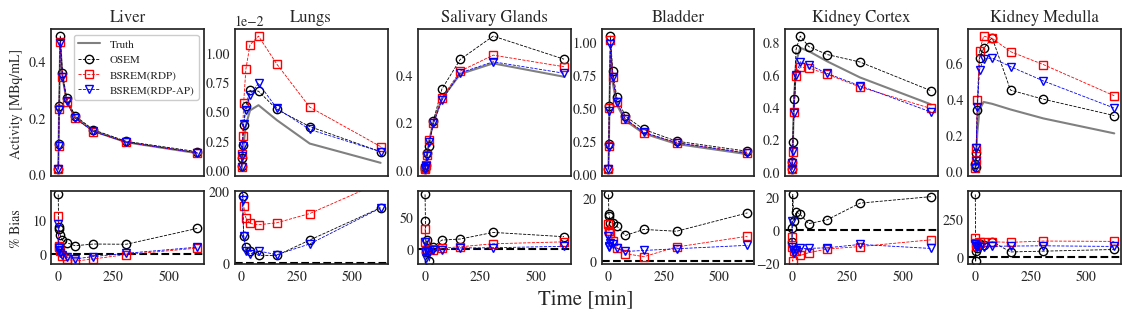

In [6]:
fig = plt.figure(figsize=(12,2.5), tight_layout=True)
subfig_u, subfig_l = fig.subfigures(nrows=2, ncols=1, hspace=0.2, height_ratios=[1,0.5])
axes = subfig_u.subplots(nrows=1, ncols=6, gridspec_kw={"wspace":0.2})
for i, ax in enumerate(axes):
    plt.sca(ax)
    plt.plot(time, GT_dict[organs[i]], color='grey', label='Truth')
    plt.plot(time[:N], fs_noprior_dict[organs[i]], 'o--', color='k', label='OSEM', lw=0.6, markerfacecolor='none')
    plt.plot(time[:N], fs_RDP_dict[organs[i]], 's--', color='r', label='BSREM(RDP)', lw=0.6, markerfacecolor='none')
    plt.plot(time[:N], fs_RDPAP_dict[organs[i]], 'v--', color='b', label='BSREM(RDP-AP)', lw=0.6, markerfacecolor='none')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.ticklabel_format(style='scientific', scilimits=(-2,6))
    plt.title(organs_title[organs[i]])
plt.sca(axes[0])
plt.legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
subfig_u.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Activity [MBq/mL]", fontsize=10)
axes = subfig_l.subplots(nrows=1, ncols=6, gridspec_kw={"wspace":0.2})
for i, ax in enumerate(axes):
    plt.sca(ax)
    plt.plot(time[:N], 100*fs_noprior_dict[organs[i]]/ GT_dict[organs[i]][:N] - 100, 'o--', color='k', label='OSEM', lw=0.6, markerfacecolor='none')
    plt.plot(time[:N], 100*fs_RDP_dict[organs[i]]/ GT_dict[organs[i]][:N] - 100, 's--', color='r', label='BSREM(RDP)', lw=0.6, markerfacecolor='none')
    plt.plot(time[:N], 100*fs_RDPAP_dict[organs[i]]/ GT_dict[organs[i]][:N] - 100, 'v--', color='b', label='BSREM(RDP-AP)', lw=0.6, markerfacecolor='none')
    plt.axhline(0, color='k', ls='--', zorder=-100000)
axes[1].set_ylim(top=200)
subfig_l.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time [min]", fontsize=15)
plt.ylabel("% Bias", fontsize=10)
plt.savefig('TAC.png',bbox_inches='tight', dpi=300)

Specific stats for paper results

In [16]:
def compute_mean_bias(f, organ):
    pct = 100*f[organ]/ GT_dict[organ] - 100
    return np.mean(np.abs(pct[4:]))

In [19]:
for organ in organs:
    print(f'{organ}')
    print(f'No Prior: {compute_mean_bias(fs_noprior_dict, organ):.2f}%')
    print(f'RDP: {compute_mean_bias(fs_RDP_dict, organ):.2f}%')
    print(f'RDP-AP: {compute_mean_bias(fs_RDPAP_dict, organ):.2f}%')
    print('')

liver
No Prior: 3.75%
RDP: 1.28%
RDP-AP: 0.94%

r_lung
No Prior: 56.37%
RDP: 136.04%
RDP-AP: 53.77%

salivary
No Prior: 15.98%
RDP: 4.17%
RDP-AP: 2.79%

bladder
No Prior: 11.07%
RDP: 4.46%
RDP-AP: 4.16%

r_kidney_cortex
No Prior: 11.21%
RDP: 11.73%
RDP-AP: 11.06%

r_kidney_medulla
No Prior: 62.78%
RDP: 97.90%
RDP-AP: 67.46%

